#Importing dependencies


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
#from keras.callbacks import EarlyStopping
from keras.layers import ConvLSTM2D

# loading the dataset and data exploration



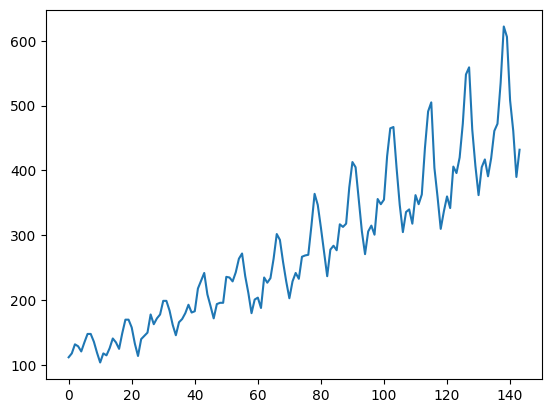

In [3]:
dataframe = read_csv('AirPassengers.csv', usecols=[1])
plt.plot(dataframe)

# Preprocessing the data to make it compatible fot the Neural Network

In [4]:
#Convert pandas dataframe to numpy array
#COnvert values to float
dataset = dataframe.values
dataset = dataset.astype('float32') 


In [5]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset for the model to undertand patterns in a better way
scaler = MinMaxScaler(feature_range=(0, 1)) 
#Also try QuantileTransformer
dataset = scaler.fit_transform(dataset)


We cannot use random way of splitting dataset into train and test as
the sequence of events is important for time series.
So let us take first 60% values for train and the remaining 1/3 for testing
Split into train and test sets

In [6]:
train_size = int(len(dataset) * 0.66)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

We cannot fit the model like we normally do for image processing where we have
X and Y. We need to transform our data into something that looks like X and Y values.
* This way it can be trained on a sequence rather than indvidual datapoints. 
Let us convert into n number of columns for X where we feed sequence of numbers
then the final column as Y where we provide the next number in the sequence as output.
* So let us convert an array of values into a dataset matrix
seq_size is the number of previous time steps to use as 
input variables to predict the next time period.

* creates a dataset where X is the number of passengers at a given time (t, t-1, t-2...) and Y is the number of passengers at the next time (t + 1).

In [7]:
def to_sequences(dataset, seq_size=1):
    x = []
    y = []

    for i in range(len(dataset)-seq_size-1):
        #print(i)
        window = dataset[i:(i+seq_size), 0]
        x.append(window)
        y.append(dataset[i+seq_size, 0])
        
    return np.array(x),np.array(y)

In [8]:
seq_size = 10  # Number of time steps to look back 
#Larger sequences (look further back) may improve forecasting.

trainX_1, trainY_1 = to_sequences(train, seq_size)
testX_1, testY_1 = to_sequences(test, seq_size)

print("Shape of training set: {}".format(trainX_1.shape))
print("Shape of test set: {}".format(testX_1.shape))

Shape of training set: (84, 10)
Shape of test set: (38, 10)


In [9]:
# Reshape input to be [samples, time steps, features]
trainX_1 = np.reshape(trainX_1, (trainX_1.shape[0], 1, trainX_1.shape[1]))
testX_1 = np.reshape(testX_1, (testX_1.shape[0], 1, testX_1.shape[1]))

#creaing model with a single LSTM
print('Single LSTM with hidden Dense...')
model = Sequential()
model.add(LSTM(64, input_shape=(None, seq_size)))
model.add(Dense(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
##monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=20, 
##                        verbose=1, mode='auto', restore_best_weights=True)
print('Train...')

Single LSTM with hidden Dense...
Train...


In [10]:
#Setting parameteres for fiitnig the model
model.fit(trainX_1, trainY_1, validation_data=(testX_1, testY_1),
          verbose=2, epochs=100)

Epoch 1/100
3/3 - 2s - loss: 0.0521 - val_loss: 0.2229 - 2s/epoch - 775ms/step
Epoch 2/100
3/3 - 0s - loss: 0.0320 - val_loss: 0.1389 - 62ms/epoch - 21ms/step
Epoch 3/100
3/3 - 0s - loss: 0.0173 - val_loss: 0.0778 - 29ms/epoch - 10ms/step
Epoch 4/100
3/3 - 0s - loss: 0.0094 - val_loss: 0.0400 - 30ms/epoch - 10ms/step
Epoch 5/100
3/3 - 0s - loss: 0.0059 - val_loss: 0.0244 - 31ms/epoch - 10ms/step
Epoch 6/100
3/3 - 0s - loss: 0.0078 - val_loss: 0.0220 - 28ms/epoch - 9ms/step
Epoch 7/100
3/3 - 0s - loss: 0.0093 - val_loss: 0.0223 - 29ms/epoch - 10ms/step
Epoch 8/100
3/3 - 0s - loss: 0.0092 - val_loss: 0.0215 - 29ms/epoch - 10ms/step
Epoch 9/100
3/3 - 0s - loss: 0.0078 - val_loss: 0.0216 - 28ms/epoch - 9ms/step
Epoch 10/100
3/3 - 0s - loss: 0.0064 - val_loss: 0.0243 - 31ms/epoch - 10ms/step
Epoch 11/100
3/3 - 0s - loss: 0.0057 - val_loss: 0.0283 - 31ms/epoch - 10ms/step
Epoch 12/100
3/3 - 0s - loss: 0.0056 - val_loss: 0.0311 - 31ms/epoch - 10ms/step
Epoch 13/100
3/3 - 0s - loss: 0.0057 - v

In [11]:
# making predictions
trainPredict_1 = model.predict(trainX_1)
testPredict_1 = model.predict(testX_1)

2/2 [==============================] - 0s 3ms/step


In [12]:
# Invert predictions back to prescaled values This is to compare with original input values
#Since we used minmaxscaler we can now use scaler.inverse_transform
#to invert the transformation.
trainPredict_1 = scaler.inverse_transform(trainPredict_1)
trainY_1 = scaler.inverse_transform([trainY_1])
testPredict_1 = scaler.inverse_transform(testPredict_1)
testY_1 = scaler.inverse_transform([testY_1])


In [15]:
# calculate root mean squared error
trainScore_1 = math.sqrt(mean_squared_error(trainY_1[0], trainPredict_1[:,0]))
print('Train Score: %.2f RMSE' % (trainScore_1))

testScore_1 = math.sqrt(mean_squared_error(testY_1[0], testPredict_1[:,0]))
print('Test Score: %.2f RMSE' % (testScore_1))

Train Score: 19.80 RMSE
Test Score: 46.30 RMSE


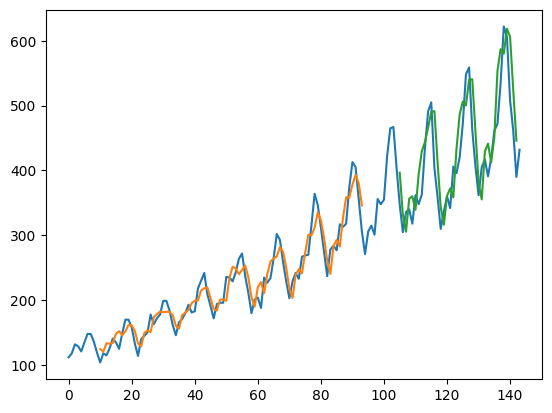

In [35]:
# shift train predictions for plotting
#we must shift the predictions so that they align on the x-axis with the original dataset. 
trainPredictPlot_1 = np.empty_like(dataset)
trainPredictPlot_1[:, :] = np.nan
trainPredictPlot_1[seq_size:len(trainPredict_1)+seq_size, :] = trainPredict_1

# shift test predictions for plotting
testPredictPlot_1 = np.empty_like(dataset)
testPredictPlot_1[:, :] = np.nan
testPredictPlot_1[len(trainPredict_1)+(seq_size*2)+1:len(dataset)-1, :] = testPredict_1

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot_1)
plt.plot(testPredictPlot_1)
plt.show()

# Stacked LSTM

In [40]:
seq_size = 10  # Number of time steps to look back 
#Larger sequences (look further back) may improve forecasting.

trainX_2, trainY_2 = to_sequences(train, seq_size)
testX_2, testY_2 = to_sequences(test, seq_size)

#Stacked LSTM with 1 hidden dense layer
#reshape input to be [samples, time steps, features]
trainX_2 = np.reshape(trainX_2, (trainX_2.shape[0], 1, trainX_2.shape[1]))
testX_2 = np.reshape(testX_2, (testX_2.shape[0], 1, testX_2.shape[1]))

model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(None, seq_size)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(32))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()
print('Train...')

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, None, 50)          12200     
                                                                 
 lstm_12 (LSTM)              (None, 50)                20200     
                                                                 
 dense_12 (Dense)            (None, 32)                1632      
                                                                 
 dense_13 (Dense)            (None, 1)                 33        
                                                                 
Total params: 34,065
Trainable params: 34,065
Non-trainable params: 0
_________________________________________________________________
Train...


In [41]:
#Setting parameteres for fiitnig the model
model.fit(trainX_2, trainY_2, validation_data=(testX_2, testY_2),
          verbose=2, epochs=100)

Epoch 1/100
3/3 - 3s - loss: 0.0628 - val_loss: 0.3371 - 3s/epoch - 863ms/step
Epoch 2/100
3/3 - 0s - loss: 0.0492 - val_loss: 0.2926 - 31ms/epoch - 10ms/step
Epoch 3/100
3/3 - 0s - loss: 0.0376 - val_loss: 0.2481 - 34ms/epoch - 11ms/step
Epoch 4/100
3/3 - 0s - loss: 0.0275 - val_loss: 0.2046 - 33ms/epoch - 11ms/step
Epoch 5/100
3/3 - 0s - loss: 0.0204 - val_loss: 0.1628 - 34ms/epoch - 11ms/step
Epoch 6/100
3/3 - 0s - loss: 0.0156 - val_loss: 0.1253 - 31ms/epoch - 10ms/step
Epoch 7/100
3/3 - 0s - loss: 0.0138 - val_loss: 0.0950 - 31ms/epoch - 10ms/step
Epoch 8/100
3/3 - 0s - loss: 0.0139 - val_loss: 0.0745 - 32ms/epoch - 11ms/step
Epoch 9/100
3/3 - 0s - loss: 0.0147 - val_loss: 0.0649 - 35ms/epoch - 12ms/step
Epoch 10/100
3/3 - 0s - loss: 0.0148 - val_loss: 0.0631 - 31ms/epoch - 10ms/step
Epoch 11/100
3/3 - 0s - loss: 0.0141 - val_loss: 0.0667 - 31ms/epoch - 10ms/step
Epoch 12/100
3/3 - 0s - loss: 0.0128 - val_loss: 0.0712 - 32ms/epoch - 11ms/step
Epoch 13/100
3/3 - 0s - loss: 0.0121 -

In [42]:
# making predictions
trainPredict_2 = model.predict(trainX_2)
testPredict_2 = model.predict(testX_2)

2/2 [==============================] - 0s 5ms/step


Train Score: 16.12 RMSE
Test Score: 47.34 RMSE


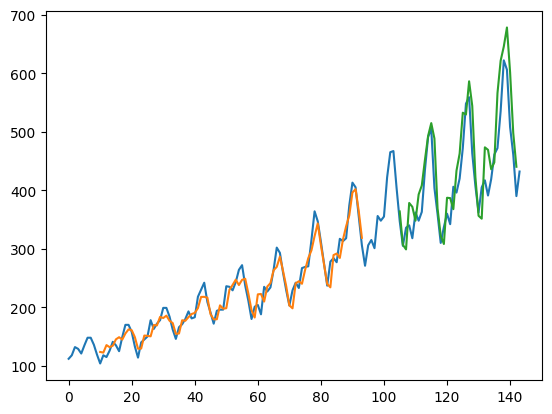

In [43]:
# invert predictions back to prescaled values
#This is to compare with original input values
#SInce we used minmaxscaler we can now use scaler.inverse_transform
#to invert the transformation.
trainPredict_2 = scaler.inverse_transform(trainPredict_2)
trainY_2 = scaler.inverse_transform([trainY_2])
testPredict_2 = scaler.inverse_transform(testPredict_2)
testY_2 = scaler.inverse_transform([testY_2])

# calculate root mean squared error
trainScore_2 = math.sqrt(mean_squared_error(trainY_2[0], trainPredict_2[:,0]))
print('Train Score: %.2f RMSE' % (trainScore_2))

testScore_2 = math.sqrt(mean_squared_error(testY_2[0], testPredict_2[:,0]))
print('Test Score: %.2f RMSE' % (testScore_2))

# shift train predictions for plotting
#we must shift the predictions so that they align on the x-axis with the original dataset. 
trainPredictPlot_2 = np.empty_like(dataset)
trainPredictPlot_2[:, :] = np.nan
trainPredictPlot_2[seq_size:len(trainPredict_2)+seq_size, :] = trainPredict_2

# shift test predictions for plotting
testPredictPlot_2 = np.empty_like(dataset)
testPredictPlot_2[:, :] = np.nan
testPredictPlot_2[len(trainPredict_2)+(seq_size*2)+1:len(dataset)-1, :] = testPredict_2

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot_2)
plt.plot(testPredictPlot_2)
plt.show()


#Bidirection LSTM

In [56]:
seq_size = 10  # Number of time steps to look back 
#Larger sequences (look further back) may improve forecasting.

trainX_3, trainY_3 = to_sequences(train, seq_size)
testX_3, testY_3 = to_sequences(test, seq_size)

#Bidirectional LSTM
#reshape input to be [samples, time steps, features]
trainX_3 = np.reshape(trainX_3, (trainX_3.shape[0], 1, trainX_3.shape[1]))
testX_3 = np.reshape(testX_3, (testX_3.shape[0], 1, testX_3.shape[1]))

#For some sequence forecasting problems we may need LSTM to learn
# sequence in both forward and backward directions
from keras.layers import Bidirectional
model = Sequential()
model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(None, seq_size)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
print('Train...')

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirectio  (None, 100)              24400     
 nal)                                                            
                                                                 
 dense_17 (Dense)            (None, 1)                 101       
                                                                 
Total params: 24,501
Trainable params: 24,501
Non-trainable params: 0
_________________________________________________________________
Train...


In [57]:
#Setting parameteres for fiitnig the model
model.fit(trainX_3, trainY_3, validation_data=(testX_3, testY_3),
          verbose=2, epochs=100)

Epoch 1/100
3/3 - 3s - loss: 0.0812 - val_loss: 0.4255 - 3s/epoch - 837ms/step
Epoch 2/100
3/3 - 0s - loss: 0.0695 - val_loss: 0.3681 - 42ms/epoch - 14ms/step
Epoch 3/100
3/3 - 0s - loss: 0.0599 - val_loss: 0.3164 - 42ms/epoch - 14ms/step
Epoch 4/100
3/3 - 0s - loss: 0.0507 - val_loss: 0.2705 - 42ms/epoch - 14ms/step
Epoch 5/100
3/3 - 0s - loss: 0.0425 - val_loss: 0.2285 - 38ms/epoch - 13ms/step
Epoch 6/100
3/3 - 0s - loss: 0.0358 - val_loss: 0.1897 - 43ms/epoch - 14ms/step
Epoch 7/100
3/3 - 0s - loss: 0.0290 - val_loss: 0.1548 - 39ms/epoch - 13ms/step
Epoch 8/100
3/3 - 0s - loss: 0.0234 - val_loss: 0.1233 - 49ms/epoch - 16ms/step
Epoch 9/100
3/3 - 0s - loss: 0.0183 - val_loss: 0.0957 - 38ms/epoch - 13ms/step
Epoch 10/100
3/3 - 0s - loss: 0.0143 - val_loss: 0.0722 - 37ms/epoch - 12ms/step
Epoch 11/100
3/3 - 0s - loss: 0.0114 - val_loss: 0.0531 - 37ms/epoch - 12ms/step
Epoch 12/100
3/3 - 0s - loss: 0.0088 - val_loss: 0.0392 - 45ms/epoch - 15ms/step
Epoch 13/100
3/3 - 0s - loss: 0.0071 -

In [58]:
# making predictions
trainPredict_3 = model.predict(trainX_3)
testPredict_3 = model.predict(testX_3)

2/2 [==============================] - 0s 7ms/step


Train Score: 27.50 RMSE
Test Score: 78.26 RMSE


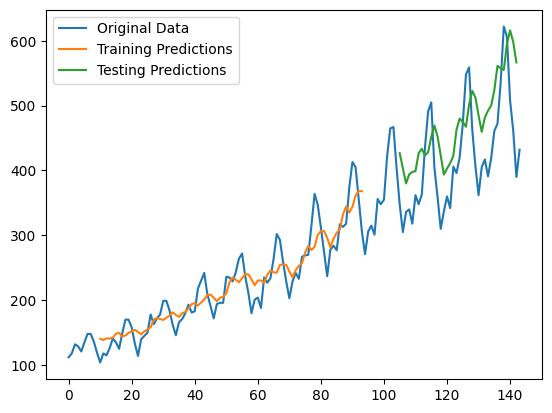

In [59]:
# invert predictions back to prescaled values
#This is to compare with original input values
#SInce we used minmaxscaler we can now use scaler.inverse_transform
#to invert the transformation.
trainPredict_3 = scaler.inverse_transform(trainPredict_3)
trainY_3 = scaler.inverse_transform([trainY_3])
testPredict_3 = scaler.inverse_transform(testPredict_3)
testY_3 = scaler.inverse_transform([testY_3])

# calculate root mean squared error
trainScore_3 = math.sqrt(mean_squared_error(trainY_3[0], trainPredict_3[:,0]))
print('Train Score: %.2f RMSE' % (trainScore_3))

testScore_3 = math.sqrt(mean_squared_error(testY_3[0], testPredict_3[:,0]))
print('Test Score: %.2f RMSE' % (testScore_3))

# shift train predictions for plotting
#we must shift the predictions so that they align on the x-axis with the original dataset. 
trainPredictPlot_3 = np.empty_like(dataset)
trainPredictPlot_3[:, :] = np.nan
trainPredictPlot_3[seq_size:len(trainPredict_3)+seq_size, :] = trainPredict_3

# shift test predictions for plotting
testPredictPlot_3 = np.empty_like(dataset)
testPredictPlot_3[:, :] = np.nan
testPredictPlot_3[len(trainPredict_3)+(seq_size*2)+1:len(dataset)-1, :] = testPredict_3

import matplotlib.pyplot as plt

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset), label='Original Data')
plt.plot(trainPredictPlot_3, label='Training Predictions')
plt.plot(testPredictPlot_3, label='Testing Predictions')

# Add legend
plt.legend()

# Display the plot
plt.show()

#Convolution LSTM 

In [51]:
def to_sequences(dataset, seq_size=1):
    x = []
    y = []

    for i in range(len(dataset)-seq_size-1):
        #print(i)
        window = dataset[i:(i+seq_size), 0]
        x.append(window)
        y.append(dataset[i+seq_size, 0])
        
    return np.array(x),np.array(y)
    

seq_size = 10  # Number of time steps to look back 
#Larger sequences (look further back) may improve forecasting.

trainX_4, trainY_4 = to_sequences(train, seq_size)
testX_4, testY_4 = to_sequences(test, seq_size)


print("Shape of training set: {}".format(trainX_4.shape))
print("Shape of test set: {}".format(testX_4.shape))



Shape of training set: (84, 10)
Shape of test set: (38, 10)


In [52]:
#ConvLSTM
#The layer expects input as a sequence of two-dimensional images, 
#therefore the shape of input data must be: [samples, timesteps, rows, columns, features]

trainX_4 = trainX_4.reshape((trainX_4.shape[0], 1, 1, 1, seq_size))
testX_4 = testX_4.reshape((testX_4.shape[0], 1, 1, 1, seq_size))

model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,1), activation='relu', input_shape=(1, 1, 1, seq_size)))
model.add(Flatten())
model.add(Dense(32))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
#print('Train...')


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 1, 1, 64)          19200     
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense_15 (Dense)            (None, 32)                2080      
                                                                 
 dense_16 (Dense)            (None, 1)                 33        
                                                                 
Total params: 21,313
Trainable params: 21,313
Non-trainable params: 0
_________________________________________________________________


In [53]:
#Setting parameteres for fiitnig the model
model.fit(trainX_4, trainY_4, validation_data=(testX_4, testY_4),
          verbose=2, epochs=100)

Epoch 1/100
3/3 - 4s - loss: 0.0605 - val_loss: 0.2953 - 4s/epoch - 1s/step
Epoch 2/100
3/3 - 0s - loss: 0.0439 - val_loss: 0.2275 - 36ms/epoch - 12ms/step
Epoch 3/100
3/3 - 0s - loss: 0.0303 - val_loss: 0.1670 - 39ms/epoch - 13ms/step
Epoch 4/100
3/3 - 0s - loss: 0.0193 - val_loss: 0.1148 - 34ms/epoch - 11ms/step
Epoch 5/100
3/3 - 0s - loss: 0.0123 - val_loss: 0.0725 - 37ms/epoch - 12ms/step
Epoch 6/100
3/3 - 0s - loss: 0.0084 - val_loss: 0.0438 - 36ms/epoch - 12ms/step
Epoch 7/100
3/3 - 0s - loss: 0.0084 - val_loss: 0.0285 - 39ms/epoch - 13ms/step
Epoch 8/100
3/3 - 0s - loss: 0.0095 - val_loss: 0.0233 - 57ms/epoch - 19ms/step
Epoch 9/100
3/3 - 0s - loss: 0.0100 - val_loss: 0.0230 - 40ms/epoch - 13ms/step
Epoch 10/100
3/3 - 0s - loss: 0.0092 - val_loss: 0.0252 - 40ms/epoch - 13ms/step
Epoch 11/100
3/3 - 0s - loss: 0.0080 - val_loss: 0.0296 - 44ms/epoch - 15ms/step
Epoch 12/100
3/3 - 0s - loss: 0.0072 - val_loss: 0.0351 - 44ms/epoch - 15ms/step
Epoch 13/100
3/3 - 0s - loss: 0.0067 - va

In [54]:
# making predictions
trainPredict_4 = model.predict(trainX_4)
testPredict_4 = model.predict(testX_4)

2/2 [==============================] - 0s 7ms/step


Train Score: 18.45 RMSE
Test Score: 44.98 RMSE


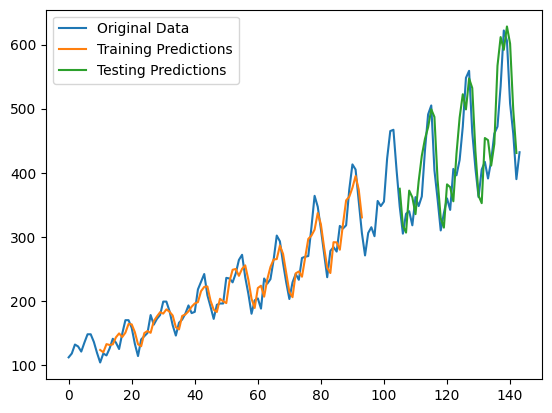

In [60]:
# invert predictions back to prescaled values
#This is to compare with original input values
#SInce we used minmaxscaler we can now use scaler.inverse_transform
#to invert the transformation.
trainPredict_4 = scaler.inverse_transform(trainPredict_4)
trainY_4 = scaler.inverse_transform([trainY_4])
testPredict_4 = scaler.inverse_transform(testPredict_4)
testY_4 = scaler.inverse_transform([testY_4])

# calculate root mean squared error
trainScore_4 = math.sqrt(mean_squared_error(trainY_4[0], trainPredict_4[:,0]))
print('Train Score: %.2f RMSE' % (trainScore_4))

testScore_4 = math.sqrt(mean_squared_error(testY_4[0], testPredict_4[:,0]))
print('Test Score: %.2f RMSE' % (testScore_4))

# shift train predictions for plotting
#we must shift the predictions so that they align on the x-axis with the original dataset. 
trainPredictPlot_4 = np.empty_like(dataset)
trainPredictPlot_4[:, :] = np.nan
trainPredictPlot_4[seq_size:len(trainPredict_4)+seq_size, :] = trainPredict_4

# shift test predictions for plotting
testPredictPlot_4 = np.empty_like(dataset)
testPredictPlot_4[:, :] = np.nan
testPredictPlot_4[len(trainPredict_4)+(seq_size*2)+1:len(dataset)-1, :] = testPredict_4
import matplotlib.pyplot as plt

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset), label='Original Data')
plt.plot(trainPredictPlot_4, label='Training Predictions')
plt.plot(testPredictPlot_4, label='Testing Predictions')

# Add legend
plt.legend()

# Display the plot
plt.show()

#Comparing the RMSE scores of Single LSTM, Stacked LSTM, Bidirectional LSTM and  Convolutional LSTM

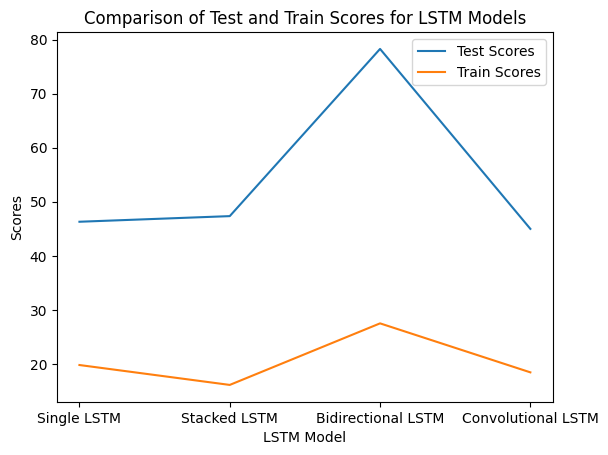

In [61]:
import matplotlib.pyplot as plt

# Test and train scores for each LSTM model
test_scores = [testScore_1, testScore_2, testScore_3, testScore_4]
train_scores = [trainScore_1, trainScore_2, trainScore_3, trainScore_4]

# Model labels
model_labels = ['Single LSTM', 'Stacked LSTM', 'Bidirectional LSTM', 'Convolutional LSTM']

# Plotting the scores
plt.plot(model_labels, test_scores, label='Test Scores')
plt.plot(model_labels, train_scores, label='Train Scores')

# Add labels and title
plt.xlabel('LSTM Model')
plt.ylabel('Scores')
plt.title('Comparison of Test and Train Scores for LSTM Models')

# Add legend
plt.legend()

# Display the plot
plt.show()
